In [1]:
# CBF imports
import scipy
import numpy as np
import matplotlib.patches as pat
import matplotlib.pyplot  as plt
from data      import make_rectangle, insert_shape, plot_data, plot_angle_data, get_gparams
from agent     import Agent
from controls  import hjb_controls, hjb_controls_parallel
#from rbf       import get_h, get_h_curr
from utils     import plot_cbf, plot_angles, _plot_angles, quad_plot, union, intersection, difference

# HJB imports 
import jax
import jax.numpy            as jnp
import matplotlib.animation as anim
import matplotlib.pyplot    as plt
import plotly.graph_objects as go
import hj_reachability      as hj
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

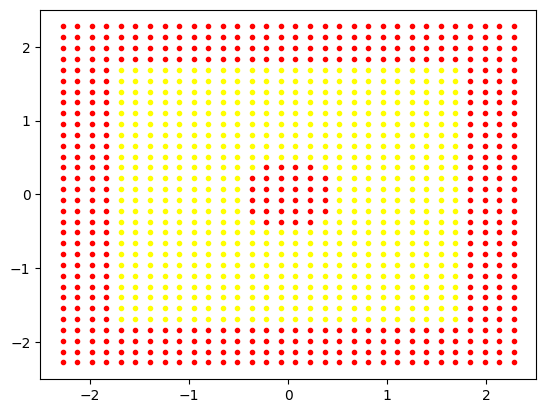

spacing: 0.14677419354838708


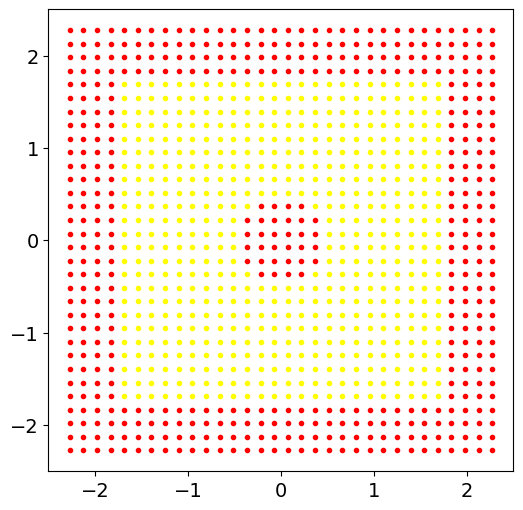

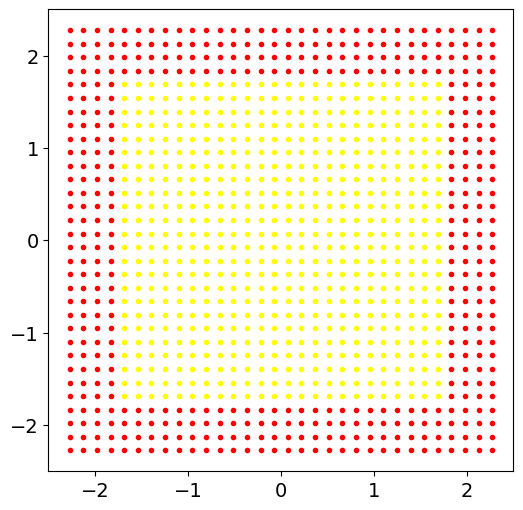

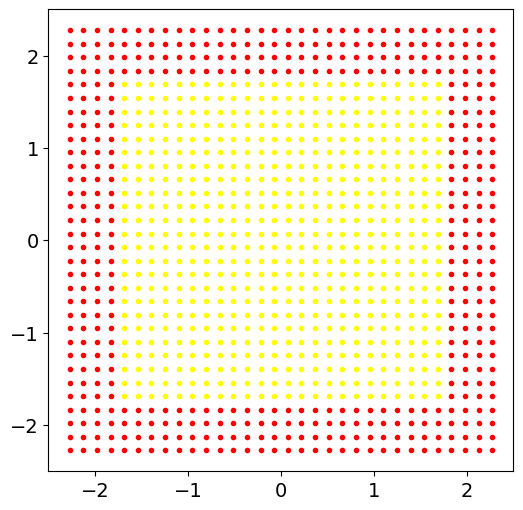

In [2]:
#########################
### Data Construction ###
#########################

width         = 3.5
density       = 50
unsafe_margin = 0.3
thn           = 24

# make grid and obstacles
obs_funcs = []
grid, params, obs_dict, is_obs_grid = make_rectangle(height=width, width=width, density=density, unsafe_margin=unsafe_margin, center=(0,0), return_params=True)
#obs_dict = insert_shape(np.array([0,  1.5]), grid, obs_dict, shape='circle', scale=0.75, theta=0)
obs_dict, is_obs_circ = insert_shape(np.array([0, 0]), grid, obs_dict, shape='circle', scale=0.50, theta=0)
obstacles = np.array([pt for pt in grid if obs_dict[tuple(np.round(pt, 3))] != 0])
obs_funcs.append(is_obs_grid)
obs_funcs.append(is_obs_circ)

from data import check_obs
for pt in grid:
    if check_obs(pt, obs_funcs):
        plt.plot(pt[0], pt[1], marker='.', color="r", linestyle="none")
    else:
        plt.plot(pt[0], pt[1], marker='.', color="yellow", linestyle="none")
plt.show()

# grids for centers and unsafe samples
c_grid, c_obs_dict = make_rectangle(height=width, width=width, density=density/1, unsafe_margin=unsafe_margin, center=(0,0))
s_grid, s_obs_dict = make_rectangle(height=width, width=width, density=density/1, unsafe_margin=unsafe_margin, center=(0,0))


# initialize hjb grid
lo, hi, n, spacing = params
print("spacing:", spacing)
lo = lo + (0       ,)
hi = hi + (2*jnp.pi,)
n  = n  + (thn     ,)

hjb_grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo, hi), n, periodic_dims=2)

plot_data(  grid,   obs_dict, size=6)
plot_data(c_grid, c_obs_dict, size=6)
plot_data(s_grid, s_obs_dict, size=6)

(1024, 2)
(32, 32, 24)


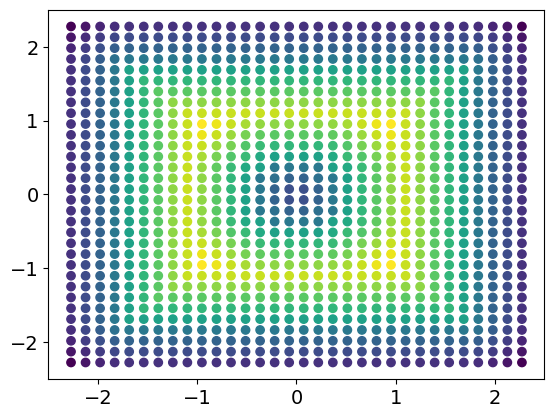

In [3]:
#####################################
### Make Signed Distance Function ###
#####################################

l = np.empty(hjb_grid.states.shape[:-1])

obs_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] != 0])
fre_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] == 0])

for i in range(n[0]):
    for j in range(n[1]):
        for k in range(n[2]):
            if obs_dict[tuple(np.round(np.array(hjb_grid.states[i, j, k, :-1]), 3))] != 0:
                l[i, j, k] = -np.min(np.linalg.norm(fre_coords - hjb_grid.states[i, j, k, :2], axis=1))
            else:
                l[i, j, k] =  np.min(np.linalg.norm(obs_coords - hjb_grid.states[i, j, k, :2], axis=1))

print(grid.shape)
print(l.shape)
plt.scatter(grid[:,0], grid[:,1], c=l[...,0].reshape(-1, 1))
plt.show()

In [4]:
############################
### Configure HJB Solver ###
############################

gamma  = 0.20
cbvf   = True
umax   = 0.40
utype  ="box"
V      = 0.10
l      = jnp.array(l)
values = l 
solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube,
                                                  value_postprocessor      =hj.solver.static_obstacle(l))

In [5]:
####################################
### Solver PDE for final surface ###
####################################

dynamics = hj.systems.Bicycle(gamma=gamma, V=V, umax=umax)
time = 0.
target_time = -500
target_values = hj.step(solver_settings, dynamics, hjb_grid, time, values, target_time)

100%|##############################| 500.0000/500.0 [00:03<00:00, 158.81sim_s/s]


<Figure size 640x480 with 0 Axes>

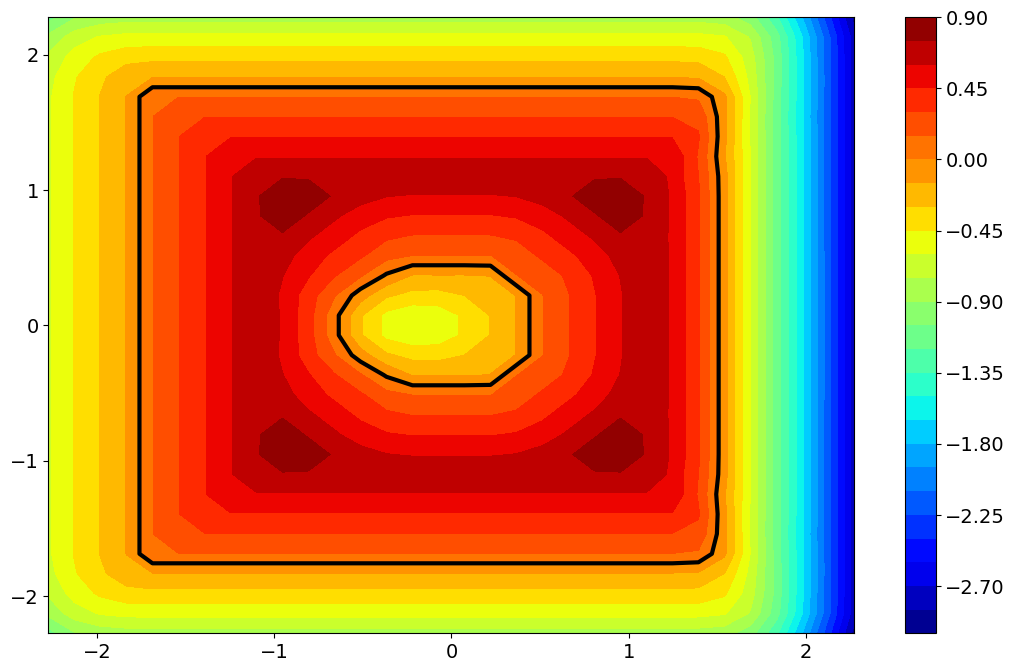

In [6]:
##########################
### Plot final surface ###
##########################

plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(hjb_grid.coordinate_vectors[0], hjb_grid.coordinate_vectors[1], target_values[:, :, 0].T, levels=30)
plt.colorbar()
plt.contour(hjb_grid.coordinate_vectors[0],
            hjb_grid.coordinate_vectors[1],
            target_values[:, :, 0].T,
            levels=0,
            colors="black",
            linewidths=3)

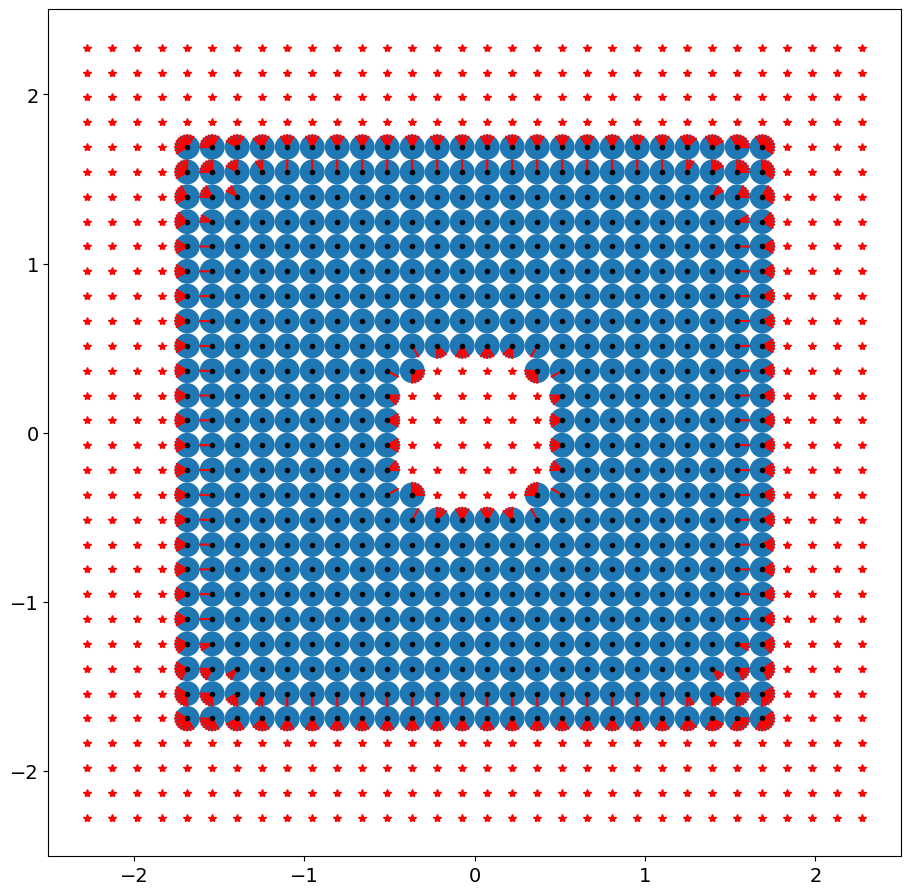

In [7]:
#######################################
### Plot V at each x,y using arrows ###
#######################################
ddegrees = 2

fig, ax = plt.subplots(figsize=(11,11))

plt.rc('xtick', labelsize=14)                                                
plt.rc('ytick', labelsize=14)                                                

for x in grid:                                                               
    if obs_dict[tuple(np.round(x, 3))] == 0:                               
        ax.plot(x[0], x[1], color="black", marker=".", linestyle="none")   
        A = pat.Annulus(x, spacing/2, spacing/2-0.01)
        ax.add_patch(A)
        pt = np.array([x[0], x[1], 0])
        idx = hjb_grid.nearest_index(pt)[:2]
        for i, Vtheta in enumerate(target_values[idx[0], idx[1]]):
            theta = hjb_grid.states[idx[0], idx[1], i][-1]
            if Vtheta <= 0:
                B = pat.Wedge(x, spacing/2, 360/(2*np.pi)*theta - ddegrees, 360/(2*np.pi)*theta + ddegrees, width=spacing/2, color='r')  
                ax.add_patch(B)
            #else:
            #    B = pat.Wedge(  x, s/2, 360/(2*np.pi)*theta - 1, 360/(2*np.pi)*theta + 1, width=s/2, color='b')  
            #    ax.add_patch(B)
    else:
        ax.plot(x[0], x[1], color="red"   , marker="*", linestyle="none") 

plt.show()

In [8]:
##############################
### Plot V(x, y, theta(t)) ###
##############################

vmin, vmax = target_values.min(), target_values.max()
levels = np.linspace(round(vmin), round(vmax), 5*(round(vmax) - round(vmin) + 1))
fig = plt.figure(figsize=(13, 8))

def render_frame(i, colorbar=False):
    plt.contourf(hjb_grid.coordinate_vectors[0],
                 hjb_grid.coordinate_vectors[1],
                 target_values[:, :, i].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.contour(hjb_grid.coordinate_vectors[0],
                hjb_grid.coordinate_vectors[1],
                target_values[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, target_values.shape[-1], interval=50).to_html5_video())
plt.close(); animation

In [9]:
##########################################
### Solve for backwards reachable tube ###
##########################################

times = np.linspace(0, -500, 100)
initial_values = l
all_values = hj.solve(solver_settings, dynamics, hjb_grid, times, initial_values)

100%|##############################| 500.0000/500.0 [00:03<00:00, 150.13sim_s/s]


In [10]:
##########################################
### Visualize backwards reachable tube ###
##########################################

vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin), round(vmax), 15*(round(vmax) - round(vmin) + 1))
fig = plt.figure(figsize=(13, 8))

def render_frame(i, colorbar=False):
    plt.contourf(hjb_grid.coordinate_vectors[0],
                 hjb_grid.coordinate_vectors[1],
                 all_values[i, :, :, 10].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    if colorbar:
        plt.colorbar()
    plt.contour(hjb_grid.coordinate_vectors[0],
                hjb_grid.coordinate_vectors[1],
                target_values[:, :, 10].T,
                levels=0,
                colors="black",
                linewidths=3)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=50).to_html5_video())
plt.close(); animation

In [11]:
###########################
### Agent Configuration ###
###########################

bf    = 31    # csrbf order
b     =-0.5   # offset (-0.5)
s     = 0.90  #0.75# csrbf zeroing
nm    = 0.20  # nm * n_safe = number of neighbors to consider
pct   = 0.35  # num neighber percentile under which boundary
mult  = 4
utype = utype # defined w/ hjb above
umax  = umax  # defined w/ hjb above
gamma = gamma # defined w/ hjb above
solver        ='CLARABEL'
sensor_radius = 1.1
rx            = sensor_radius + 0.2 # sample radius
rc            = sensor_radius # radius around scan in which centers are chosen
init_x        =-1.1
init_y        =-1.1
init_theta    = 0

a = Agent(dynamics, np.array([init_x, init_y, init_theta]), grid, obs_dict, width         = width, 
                                                                            sensor_radius = sensor_radius,
                                                                            bf            = bf, 
                                                                            b             = b, 
                                                                            s             = s,
                                                                            utype         = utype,
                                                                            umax          = umax,
                                                                            gamma         = gamma,
                                                                            solver        = solver,
                                                                            spacing       = spacing,
                                                                            obstacles     = obstacles)

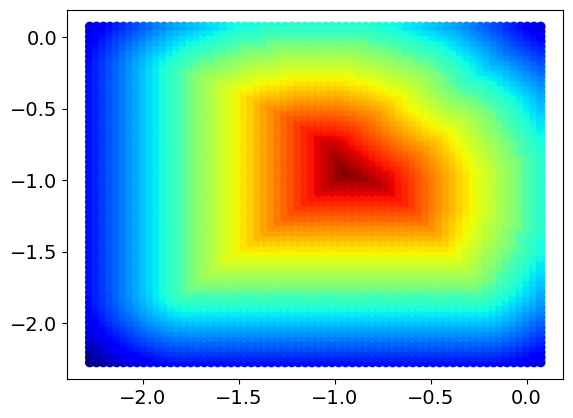

|                                              |  0.0000/0.0 [00:00<?, ?sim_s/s]


<Figure size 640x480 with 0 Axes>

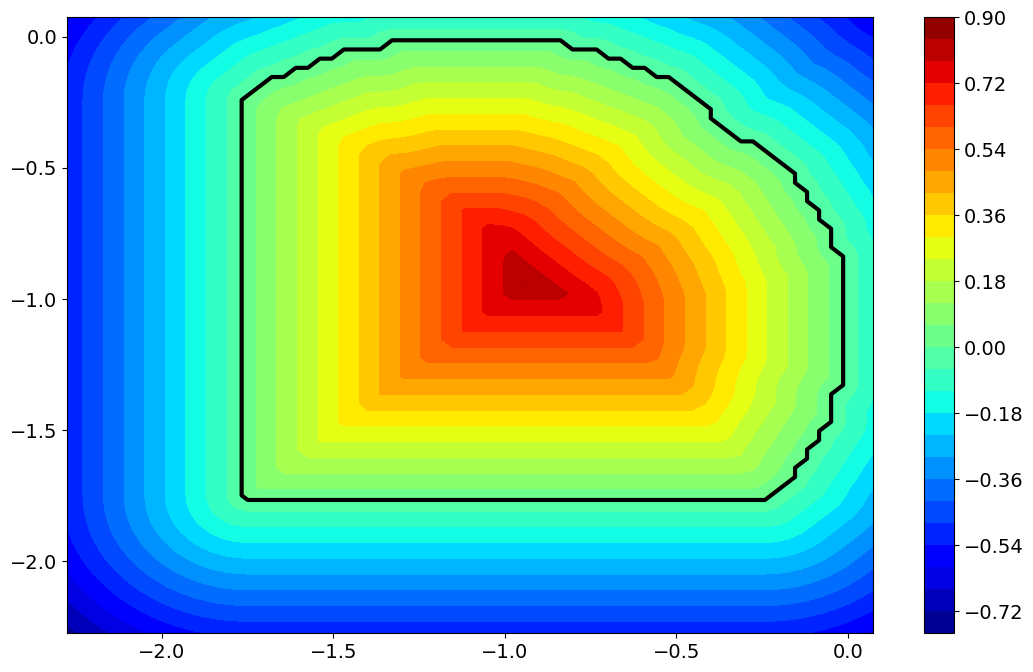

In [12]:
####################
### Initial scan ###
####################

# scan states 
pts_safe, pts_unsafe,\
             in_scan_f = a.scan(ret_in_scan_f=True) 
scan_funcs = [in_scan_f]
samples, gparams,\
is_obs_sample, x2pi_samp, x0_samp = a.sample(rx, grid=s_grid, hjb_grid=hjb_grid, hjb=True, bicycle=True, boundary_condition=True)
sample_funcs = [is_obs_sample]
loc_V, loc_hjb_grid    = a.get_local_V(gparams, obs_funcs + [is_obs_sample], thn, rx=rx, T=0, mult=mult)

In [13]:
vmin, vmax = loc_V.min(), loc_V.max()
#levels = np.linspace(round(vmin), round(vmax), 10*(round(vmax) - round(vmin) + 1))
levels = np.linspace(vmin, vmax, 10*(round(vmax) - round(vmin) + 1))
fig    = plt.figure(figsize=(13, 8))
def render_frame(i, colorbar=False):
    plt.contourf(loc_hjb_grid.coordinate_vectors[0],
                 loc_hjb_grid.coordinate_vectors[1],
                 loc_V[:, :, i].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.contour(loc_hjb_grid.coordinate_vectors[0],
                loc_hjb_grid.coordinate_vectors[1],
                loc_V[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, loc_V.shape[-1], interval=50).to_html5_video())
plt.close()
animation

In [14]:
##################################
### Configure Safe Exploration ###
##################################

DT   = 0.02   # numerical integration timestep
tol  = 0.00    # h-value at which to halt approach
eps  = 0
dx   = 0.5     # if |x'-x|<dx, approach again
tend = 90     # Duration of boundary approach
T    = 0.3     # MPC horizon (default timestep is 0.05)
N    = 3       # number of CBFs to learn

target: [ 1 -1  0]
position is [-1.1 -1.1  0. ]
start time is 0


  7%|██▉                                     | 333/4500 [00:27<04:59, 13.93it/s]

slack: 0.010084070444043757
slack: 0.01043905457438776
slack: 0.010865045963537857
slack: 0.011218272278264541


  7%|██▉                                     | 335/4500 [00:27<04:55, 14.09it/s]

slack: 0.01164265420500562
slack: 0.011994279972890662
slack: 0.0124170123859365


  8%|███                                     | 339/4500 [00:28<06:22, 10.87it/s]

slack: 0.012767231198113495
slack: 0.013168987392453488
slack: 0.01348809414765457
slack: 0.013877039359380542


  8%|███                                     | 343/4500 [00:28<05:31, 12.56it/s]

slack: 0.01419876601261205
slack: 0.014587642955116348
slack: 0.014912040541850486
slack: 0.015300798665023096


  8%|███                                     | 347/4500 [00:28<05:06, 13.55it/s]

slack: 0.015627855405136226
slack: 0.01601649326986668
slack: 0.016346188240345418
slack: 0.016734703425148514


  8%|███                                     | 351/4500 [00:29<04:53, 14.11it/s]

slack: 0.017067090952823914
slack: 0.017455489584652657
slack: 0.01779050082018074
slack: 0.018178768240338886


  8%|███▏                                    | 353/4500 [00:29<04:52, 14.19it/s]

slack: 0.018516479994692144
slack: 0.018904583839838517


  8%|███▏                                    | 357/4500 [00:29<06:18, 10.95it/s]

slack: 0.01924495735341663
slack: 0.019654564935499375
slack: 0.02003426438393697
slack: 0.020464319070011547


  8%|███▏                                    | 361/4500 [00:30<05:30, 12.54it/s]

slack: 0.020847326296486793
slack: 0.021283169038162915
slack: 0.021669294126894362


  8%|███▏                                    | 363/4500 [00:30<05:17, 13.03it/s]

slack: 0.022111021746812842
slack: 0.022500088397652364
slack: 0.022947765151920704


  8%|███▎                                    | 367/4500 [00:30<05:02, 13.65it/s]

slack: 0.023339627547072583
slack: 0.0237932537892923
slack: 0.024186466981201343


  8%|███▎                                    | 369/4500 [00:30<07:08,  9.65it/s]

slack: 0.024623194591159404
slack: 0.02500039481443357
slack: 0.02544839392958728


  8%|███▎                                    | 373/4500 [00:31<06:08, 11.21it/s]

slack: 0.025834227201816003
slack: 0.026292234471665475
slack: 0.026688254378813413


  8%|███▎                                    | 375/4500 [00:31<05:51, 11.75it/s]

slack: 0.027137676911367335
slack: 0.027509468487857257
slack: 0.027944022000545923


  8%|███▎                                    | 379/4500 [00:31<05:18, 12.92it/s]

slack: 0.0283146834682607
slack: 0.028746853189670622
slack: 0.02911545953861155


  8%|███▍                                    | 381/4500 [00:31<05:08, 13.34it/s]

slack: 0.029546493755287433
slack: 0.029912671027997
slack: 0.030342358897858603


  9%|███▍                                    | 383/4500 [00:31<05:03, 13.54it/s]

slack: 0.03070634603457109
slack: 0.031134650282351906


  9%|███▍                                    | 387/4500 [00:32<06:25, 10.66it/s]

slack: 0.03149660733638182
slack: 0.03192347886580768
slack: 0.03228337670266261


  9%|███▍                                    | 389/4500 [00:32<05:58, 11.48it/s]

slack: 0.032708931165027655
slack: 0.033066929668758877
slack: 0.033491062655277085


  9%|███▍                                    | 393/4500 [00:32<05:23, 12.68it/s]

slack: 0.03384727155000347
slack: 0.034260067927835605
slack: 0.03459836342293032


  9%|███▌                                    | 395/4500 [00:32<05:14, 13.07it/s]

slack: 0.03500335203461286
slack: 0.03533980146005589
slack: 0.0357431458947808


  9%|███▌                                    | 399/4500 [00:33<04:58, 13.74it/s]

slack: 0.03607792483419429
slack: 0.03647956324609267
slack: 0.03681291150073758


  9%|███▌                                    | 401/4500 [00:33<05:04, 13.48it/s]

slack: 0.037212766117194256
slack: 0.03754480549452282
slack: 0.03794278328533599


  9%|███▌                                    | 405/4500 [00:33<04:56, 13.80it/s]

slack: 0.038273724272229956
slack: 0.038669805487470656
slack: 0.03899978159403598


  9%|███▌                                    | 407/4500 [00:33<07:00,  9.72it/s]

slack: 0.03939384936991955
slack: 0.03972310483717544
slack: 0.04011501619193555


  9%|███▋                                    | 411/4500 [00:34<05:50, 11.66it/s]

slack: 0.040443701488761294
slack: 0.04083468357597257
slack: 0.041166078478480854


  9%|███▋                                    | 413/4500 [00:34<05:27, 12.47it/s]

slack: 0.0415613096915436
slack: 0.04189644858440814
slack: 0.04229583360248585


  9%|███▋                                    | 417/4500 [00:34<05:00, 13.57it/s]

slack: 0.04263487953632962
slack: 0.043038340391095053
slack: 0.04338110047931789
slack: 0.04378874286129396


  9%|███▋                                    | 421/4500 [00:34<04:45, 14.27it/s]

slack: 0.04413512318097872
slack: 0.0445469389609754
slack: 0.04489682202846889


  9%|███▊                                    | 423/4500 [00:35<06:51,  9.92it/s]

slack: 0.04531287350904202
slack: 0.04566617891221182
slack: 0.04608645925134442
slack: 0.046443097942935545


 10%|███▊                                    | 429/4500 [00:35<05:17, 12.81it/s]

slack: 0.04686762160273935
slack: 0.047227458530055416
slack: 0.04762903311401702
slack: 0.047957194961255896


 10%|███▊                                    | 431/4500 [00:35<05:05, 13.33it/s]

slack: 0.04835760327228211
slack: 0.04869174470858976
slack: 0.04909984522566396
slack: 0.04944013498848927


 10%|███▉                                    | 437/4500 [00:36<04:41, 14.44it/s]

slack: 0.049855652190448095
slack: 0.05020199561341066
slack: 0.0506249232100366
slack: 0.050977308338197774


 10%|███▉                                    | 439/4500 [00:36<04:43, 14.33it/s]

slack: 0.051407417450886
slack: 0.051765931388787864
slack: 0.05220300738755349


 10%|███▉                                    | 441/4500 [00:36<04:41, 14.42it/s]

slack: 0.0525678432693611
slack: 0.053010519649188334


 10%|███▉                                    | 445/4500 [00:36<06:06, 11.08it/s]

slack: 0.05338412614153855
slack: 0.05383128956910131
slack: 0.05421344813025872


 10%|███▉                                    | 447/4500 [00:37<05:41, 11.87it/s]

slack: 0.054632198696701426
slack: 0.05498624381767726
slack: 0.05540601778747513


 10%|████                                    | 451/4500 [00:37<05:17, 12.76it/s]

slack: 0.0557711663757483
slack: 0.056198100473312786
slack: 0.05652662244302754


 10%|████                                    | 453/4500 [00:37<05:09, 13.06it/s]

slack: 0.05690412772485756
slack: 0.05722705760528195
slack: 0.05760272205542811


 10%|████                                    | 455/4500 [00:37<05:00, 13.46it/s]

slack: 0.05792538716581864
slack: 0.05829944521121396


 10%|████                                    | 459/4500 [00:38<06:18, 10.67it/s]

slack: 0.05862175839662234
slack: 0.05899431775272905
slack: 0.05931621583454561
slack: 0.05968735990442313


 10%|████                                    | 463/4500 [00:38<05:23, 12.46it/s]

slack: 0.06000895194302956
slack: 0.060378710740417625
slack: 0.06069947512221755
slack: 0.0610170480670806


 10%|████▏                                   | 467/4500 [00:38<05:13, 12.86it/s]

slack: 0.06128985273153923
slack: 0.06161268384978762
slack: 0.06189078076698384


 10%|████▏                                   | 469/4500 [00:38<05:05, 13.20it/s]

slack: 0.0622188657572409
slack: 0.06250227299314226
slack: 0.06283560823534413


 11%|████▏                                   | 473/4500 [00:39<04:55, 13.64it/s]

slack: 0.06312433420349821
slack: 0.06346291639080544
slack: 0.0637568419965781
slack: 0.06410065045964061


 11%|████▏                                   | 477/4500 [00:39<06:33, 10.22it/s]

slack: 0.06439987102459614
slack: 0.0647488893761569
slack: 0.06505332690301352


 11%|████▎                                   | 479/4500 [00:39<06:04, 11.04it/s]

slack: 0.0654075201515093
slack: 0.06571727002309677
slack: 0.06607663170416327


 11%|████▎                                   | 483/4500 [00:40<05:28, 12.22it/s]

slack: 0.06635635927312473
slack: 0.06651354442700587
slack: 0.06663214874793333


 11%|████▎                                   | 485/4500 [00:40<05:25, 12.34it/s]

slack: 0.066803961562818
slack: 0.06693828019317638
slack: 0.06712465072164889


 11%|████▎                                   | 487/4500 [00:40<05:16, 12.66it/s]

slack: 0.06727453523637206


 11%|████▎                                   | 489/4500 [00:40<07:40,  8.71it/s]

slack: 0.06747542826113938
slack: 0.06764074084666526
slack: 0.06785608502362392


 11%|████▍                                   | 493/4500 [00:41<06:16, 10.64it/s]

slack: 0.06803656992687869
slack: 0.06826635459315188
slack: 0.06846194158267178


 11%|████▍                                   | 495/4500 [00:41<06:01, 11.07it/s]

slack: 0.06870610933739349
slack: 0.06891659595553623
slack: 0.06917508153255615


 11%|████▍                                   | 499/4500 [00:41<05:34, 11.96it/s]

slack: 0.06940027149881073
slack: 0.06967304665942511
slack: 0.06990992265219893


 11%|████▍                                   | 501/4500 [00:41<05:25, 12.30it/s]

slack: 0.07018269411299768
slack: 0.0704134919954779
slack: 0.07068276855406222


 11%|████▍                                   | 503/4500 [00:41<05:11, 12.82it/s]

slack: 0.0709098923163994
slack: 0.07117582753234966


 11%|████▌                                   | 507/4500 [00:42<06:21, 10.47it/s]

slack: 0.07139913247131754
slack: 0.07166166936989077
slack: 0.07188104741373316


 11%|████▌                                   | 509/4500 [00:42<05:52, 11.31it/s]

slack: 0.07214017558632742
slack: 0.07235547149558855
slack: 0.07261130076159161


 11%|████▌                                   | 513/4500 [00:42<05:18, 12.52it/s]

slack: 0.07282239979454831
slack: 0.07307483684738744
slack: 0.07328168215945471


 11%|████▌                                   | 517/4500 [00:43<04:51, 13.64it/s]

slack: 0.07353080746591505
slack: 0.07373321580827878
slack: 0.07397905806775709
slack: 0.07387235798853697


 12%|████▌                                   | 519/4500 [00:43<04:50, 13.69it/s]

slack: 0.07351983984180475
slack: 0.07308297610680979
slack: 0.07265614849468818


 12%|████▋                                   | 523/4500 [00:43<04:51, 13.62it/s]

slack: 0.07214411656181771
slack: 0.07164342665518482
slack: 0.07105633717164751


 12%|████▋                                   | 525/4500 [00:43<04:45, 13.93it/s]

slack: 0.07048202642315902
slack: 0.06982028075909384


 12%|████▋                                   | 527/4500 [00:43<06:46,  9.76it/s]

slack: 0.06917275500658225
slack: 0.0684363656185125
slack: 0.06771591934413293


 12%|████▋                                   | 531/4500 [00:44<05:38, 11.71it/s]

slack: 0.06690526684915253
slack: 0.06611228364044888
slack: 0.06522754925056701


 12%|████▋                                   | 533/4500 [00:44<05:16, 12.52it/s]

slack: 0.06436236722493371
slack: 0.06340374721045836
slack: 0.062466621049819794


 12%|████▊                                   | 537/4500 [00:44<04:57, 13.32it/s]

slack: 0.06489196300442338
slack: 0.06855127786060984
slack: 0.07215604085590001


 12%|████▊                                   | 539/4500 [00:44<05:02, 13.08it/s]

slack: 0.0758371574514127
slack: 0.07945753888588773
slack: 0.08315755593816372


 12%|████▊                                   | 541/4500 [00:44<04:55, 13.39it/s]

slack: 0.08679999088677708


 12%|████▊                                   | 543/4500 [00:45<07:01,  9.40it/s]

slack: 0.09051585426252423
slack: 0.09417767062516263
slack: 0.09791147466259312


 12%|████▊                                   | 547/4500 [00:45<05:43, 11.49it/s]

slack: 0.10159591280780078
slack: 0.10533731438152057
slack: 0.10904533758650096


 12%|████▉                                   | 549/4500 [00:45<05:22, 12.26it/s]

slack: 0.11294673197280714
slack: 0.11703674489513925
slack: 0.12108322343376042


 12%|████▉                                   | 553/4500 [00:46<05:17, 12.42it/s]

slack: 0.12502307831783666
slack: 0.12891355796065435
slack: 0.13049230145204754


 12%|████▉                                   | 555/4500 [00:46<05:11, 12.67it/s]

slack: 0.1319363060902715
slack: 0.133272424181296
slack: 0.13452322642465642


 12%|████▉                                   | 559/4500 [00:46<05:06, 12.87it/s]

slack: 0.13567257875914085
slack: 0.13673263896028273
slack: 0.1376950807963355


 12%|████▉                                   | 561/4500 [00:46<05:05, 12.90it/s]

slack: 0.1385657804566192
slack: 0.13934180524063938
slack: 0.14002494003277896


 13%|█████                                   | 565/4500 [00:47<06:36,  9.92it/s]

slack: 0.14061450153179805
slack: 0.14111136788063777
slack: 0.1415154250145118


 13%|█████                                   | 567/4500 [00:47<06:03, 10.81it/s]

slack: 0.14182677348146402
slack: 0.14204615948594135
slack: 0.14217333295447282


 13%|█████                                   | 571/4500 [00:47<05:29, 11.91it/s]

slack: 0.14220849047843237
slack: 0.14166301188047528
slack: 0.13937577861840073


 13%|█████                                   | 573/4500 [00:47<05:28, 11.97it/s]

slack: 0.13716413588204032
slack: 0.13502812804054704
slack: 0.13296726030393957


 13%|█████                                   | 575/4500 [00:47<05:13, 12.52it/s]

slack: 0.13098139502854125
slack: 0.12907030848639645


 13%|█████▏                                  | 579/4500 [00:48<06:20, 10.31it/s]

slack: 0.12723380244424842
slack: 0.12547192489727535
slack: 0.12378437471881786


 13%|█████▏                                  | 581/4500 [00:48<05:44, 11.38it/s]

slack: 0.12217051511624834
slack: 0.12063061813854122
slack: 0.1191643527760986
slack: 0.11777159443927226


 13%|█████▏                                  | 585/4500 [00:48<05:03, 12.91it/s]

slack: 0.11645211561783225
slack: 0.11520569122841273
slack: 0.11403191423562199


 13%|█████▏                                  | 589/4500 [00:49<04:42, 13.84it/s]

slack: 0.11293101320284585
slack: 0.1125650616436952
slack: 0.11294646822808865


 13%|█████▎                                  | 591/4500 [00:49<04:37, 14.09it/s]

slack: 0.11333146799630493
slack: 0.11372009760987059
slack: 0.11411235818361162


 13%|█████▎                                  | 593/4500 [00:49<04:39, 13.96it/s]

slack: 0.1145081520086622
slack: 0.11490762120604883


 13%|█████▎                                  | 597/4500 [00:49<06:09, 10.56it/s]

slack: 0.11531071000586066
slack: 0.11571745355820277
slack: 0.11612772381485727


 13%|█████▎                                  | 599/4500 [00:50<05:36, 11.60it/s]

slack: 0.11654156134554125
slack: 0.11695909982869865
slack: 0.11738009903209341
slack: 0.11780487506234737


 13%|█████▎                                  | 603/4500 [00:50<05:02, 12.90it/s]

slack: 0.11823306398520265
slack: 0.11866493736489775
slack: 0.11910033643705908


 13%|█████▍                                  | 607/4500 [00:50<04:50, 13.40it/s]

slack: 0.11953940797318763


 34%|█████████████                          | 1509/4500 [02:04<03:54, 12.75it/s]/home/paul/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|███████████████████████████████████████| 4500/4500 [06:10<00:00, 12.14it/s]


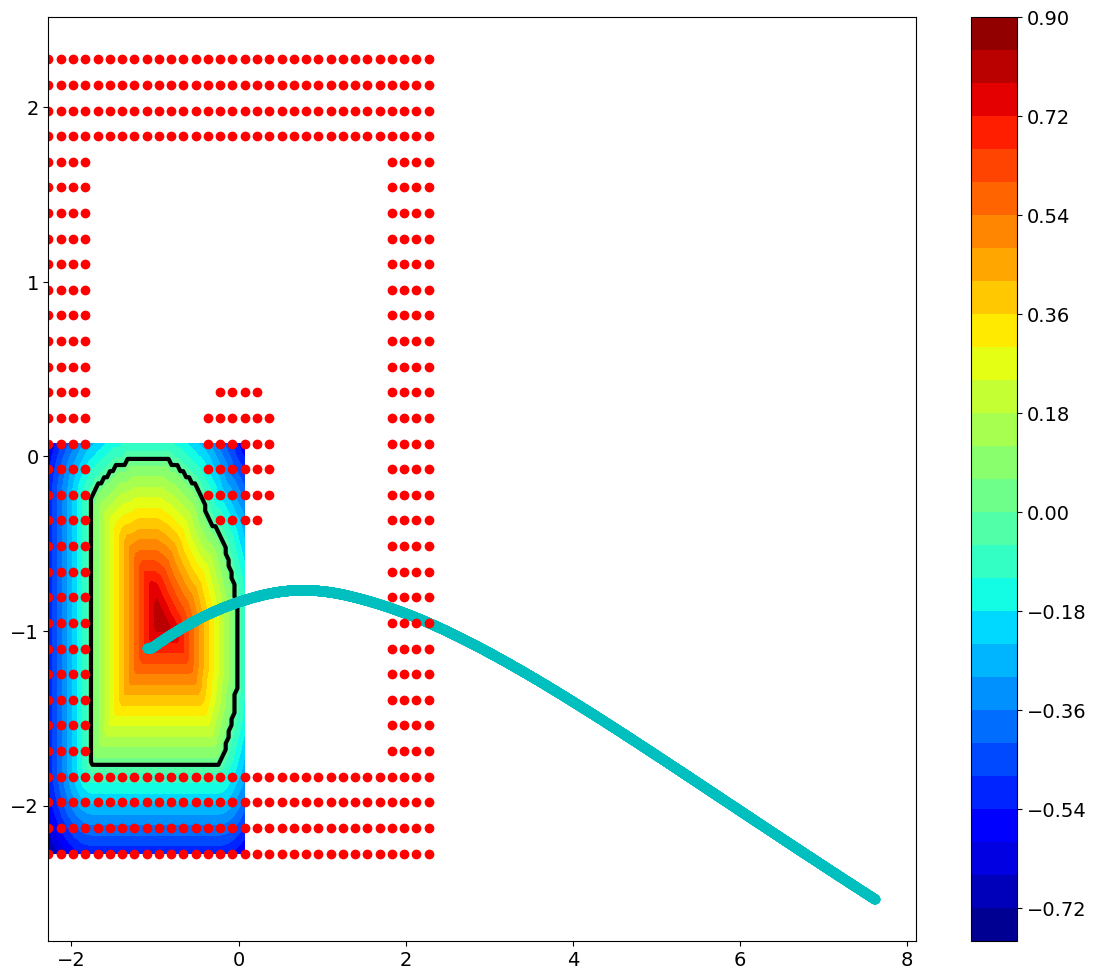

percent violation: 0.066
new position is [-1.1 -1.1  0. ]
new time is 90


ValueError: too many values to unpack (expected 2)

In [18]:
########################
### Safe Exploration ###
########################

a.pos = np.array([init_x, init_y, init_theta])

targets   = [np.array([1, -1,       0]),
             np.array([1, -1,       0]),
             np.array([1,  1, np.pi/2]),
             np.array([1,  1, np.pi/2])]
#targets   = None

for i in range(N):
    ######################
    ### Go to boundary ###
    ######################
    
    prev_pos = a.pos  
    if targets is not None:
        print("target:", targets[i]) 
        traj,usig = a.goto(targets[i], T=T, tend=tend, tol=tol, angle=a.pos[-1], manual=True, DT=DT, eps=eps, cbvf=True, grid=loc_hjb_grid, V=loc_V, bicycle=True)  
        print("dx:", np.linalg.norm(a.pos - prev_pos))
    else: 
        while np.linalg.norm(a.pos - prev_pos) <= dx:    
            target_pos   = a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)  
            target_angle = np.array([2 * np.pi * np.random.rand()])
            target       = np.hstack((target_pos, target_angle)) 
            while h(target, np.array(a.centers), np.array(a.thetas))[0] > 0:
                target_pos   = a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)
                target_angle = np.array([2 * np.pi * np.random.rand()])
                target       =  np.hstack((target_pos, target_angle)) 
            print("target:", target) 
            traj,usig = a.goto(target, T=T, tend=tend, tol=tol, angle=a.pos[-1], manual=True, DT=DT, eps=eps) 
            print("dx:", np.linalg.norm(a.pos - prev_pos))

    ####################
    ### Collect data ###
    ####################

    # scan states 
    pts_safe, pts_unsafe, in_scan_f = a.scan(ret_in_scan_f=True)
    scan_funcs.append(in_scan_f)
    samples, gparams, is_obs_sample,\
    x2pi_samp, x0_samp = a.sample(rx, grid=s_grid, hjb_grid=hjb_grid, hjb=True, bicycle=True, boundary_condition=True)
    sample_funcs.append(is_obs_sample)
    loc_V, loc_hjb_grid    = a.get_local_V(gparams, obs_funcs + [is_obs_sample], thn, rx=rx, T=500, mult=mult)

    # total data 
    from data import check_obs
    all_obs_func = lambda x: check_obs(x, obs_funcs) or (check_obs(x, sample_funcs) and not check_obs(x, scan_funcs))
    out_func     = lambda x: not ( check_obs(x, all_obs_func) or check_obs(x, scan_funcs) )
    obsamp_f     = lambda x: (check_obs(x, sample_funcs) or check_obs(x, obs_funcs)) and not (check_obs(x, scan_funcs) and not check_obs(x, obs_funcs))
    for x in grid:
        if obsamp_f(x):
            plt.plot(x[0], x[1], color='red', marker='o', linestyle='none')           
        else:
            plt.plot(x[0], x[1], color='black', marker='o', linestyle='none')
    plt.show()
    
    # collect quad plot data
    curr_data    = np.copy(np.vstack( ( curr_data, np.vstack((x_safe, x_buffer, x_unsafe)) ) ))
    curr_centers = np.copy(np.array(a.centers))
    curr_thetas  = np.copy(np.array(a.thetas))
    curr_traj    = np.copy(np.vstack( (curr_traj, traj) ))
    quad_plot_args[-1] = quad_plot_args[-1] + (curr_traj,)
    quad_plot_args.append((i+1, curr_centers, curr_thetas, curr_data))

    data_safe   = union(data_safe, np.vstack((x_buffer, x_safe)))
    data_unsafe = difference(union(data_unsafe, x_unsafe), data_safe)

    all_C = union(all_C, C)
    plot_angle_data(all_C, grid, obs_dict, spacing, safe=data_safe, unsafe=data_unsafe, title="ALL DATA")

final_pos = np.copy(a.pos)
quad_plot_args[-1] = quad_plot_args[-1] + (curr_traj,)

In [ ]:
#vmin, vmax = loc_V.min(), loc_V.max()
#levels = np.linspace(round(vmin), round(vmax), 10*(round(vmax) - round(vmin) + 1))
X = np.linspace(lo[0], hi[0], n[0])
Y = np.linspace(lo[1], hi[1], n[1])
Th = np.linspace(0, 2*np.pi, thn, endpoint=True)
hvals = np.empty((n[0], n[1], thn))
h = get_h_curr(a)
for i, x, in enumerate(X):
    for j, y in enumerate(Y):
        for k, th in enumerate(Th):
            hvals[i, j, k] = h(jnp.array([x, y, th]))[0]
hmin, hmax = hvals.min(), hvals.max() 
levels = np.linspace(hmin, hmax, 10*(round(vmax) - round(vmin) + 1))
fig    = plt.figure(figsize=(13, 8))
def render_frame(i, colorbar=False):
    plt.contourf(X,
                 Y,
                 hvals[:, :, i].T,
                 vmin=hmin,
                 vmax=hmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.title("theta: " + str(np.round(Th[i], 2)))
    plt.contour(X,
                Y,
                hvals[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, thn, interval=48).to_html5_video())
plt.close()
animation

In [ ]:
#######################################
### Sequential plot of learned CBFs ###
#######################################

fig = plt.figure(figsize=(15, 15))
axs = [fig.add_subplot(2,2,i+1) for i in range(4)]

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal') 
    
fig.subplots_adjust(wspace=0, hspace=0)

for i, args in enumerate(quad_plot_args):
    quad_plot(a, axs[i], args[0], args[1], args[2], args[3], args[4], grid, obs_dict)
plt.show()

In [ ]:
##################################################
### Learn a single CBF from all data collected ###
##################################################

n_safe = len(pts_safe)
all_obs_func = lambda x: (check_obs(x, sample_funcs) or check_obs(x, obs_funcs)) and not (check_obs(x, scan_funcs) and not check_obs(x, obs_funcs))
out_func     = lambda x: not ( check_obs(x, all_obs_func) or check_obs(x, scan_funcs) )
gparams = get_gparams(np.vstack((data_safe, data_unsafe)), hjb_grid)
loc_V, loc_hjb_grid = a.get_local_V(gparams, all_obs_func, thn, rx=None, out_func=out_func, T=500, mult=mult)
print("number of gridpoints:", loc_hjb_grid.states.flatten().shape)
all_x_buffer, all_x_safe = a.make_buffer(data_safe, int(nm * n_safe), pct, bicycle=True) 
all_u_safe = hjb_controls_parallel(a, all_x_safe, loc_hjb_grid, loc_V, verbose=True)
if x_buffer.shape[0] != 0:
    all_u_buffer = hjb_controls_parallel(a, all_x_buffer, loc_hjb_grid, loc_V)
else:
    all_u_buffer = np.array([])
all_theta = np.array(clarabel_solve_cbf(a, all_x_safe, all_u_safe, all_x_buffer, all_u_buffer, data_unsafe, gamma_safe, gamma_dyn, gamma_unsafe, centers=all_C))
h_max = plot_cbf(a, np.array(all_C)[np.newaxis,...], np.array(all_theta)[np.newaxis,...], angle=a.pos[-1], obstacles=obstacles)
_plot_angles(a, np.array(all_C)[np.newaxis,...], np.array(all_theta)[np.newaxis,...], grid, hjb_grid, obs_dict)

In [ ]:
#############################
### Plot velocity curves ####
#############################
import copy

a2 = copy.copy(a)
a2.thetas = [all_theta]
a2.centers= [all_C]

start_pos = np.array([-1.2 ,-1, 0])
target    = np.array([1, 0, np.pi])
a.pos = start_pos
a2.pos= start_pos

DT   = 0.001
tol  = 0.1
tend = 30
T    = 0.1
traj ,usig = a.goto(target, T=T, tend=tend, tol=tol, angle=a.pos[-1], manual=True, DT=DT, eps=eps)  
traj2,usig2= a2.goto(target, T=T, tend=tend, tol=tol, angle=a2.pos[-1], manual=True, DT=DT, eps=eps)  


v1 = np.linalg.norm(np.vstack((traj[1:, :-1],np.array([0,0])))  - traj, axis=1)/DT
v2 = np.linalg.norm(np.vstack((traj2[1:,:-1],np.array([0,0])))  - traj2, axis=1)/DT
plt.plot(v1[:-1], color="red", label="max of local cbfs")
plt.plot(v2[:-1], color="blue", label="baseline")
plt.ylabel("velocity")
plt.xlabel("time")
plt.legend()
plt.show()

plt.plot(usig , color="red" , label="max cbf, |u|" )
plt.plot(usig2, color="blue", label="baseline, |u|")
plt.ylabel("norm of control")
plt.xlabel("time")
plt.legend()
plt.show()

In [ ]:
X = np.linspace(lo[0], hi[0], n[0])
Y = np.linspace(lo[1], hi[1], n[1])
Th = np.linspace(0, 2*np.pi, thn, endpoint=True)
hvals = np.empty((n[0], n[1], thn))
h = get_h_curr(a2)
for i, x, in enumerate(X):
    for j, y in enumerate(Y):
        for k, th in enumerate(Th):
            hvals[i, j, k] = h(jnp.array([x, y, th]))[0]
hmin, hmax = hvals.min(), hvals.max() 
levels = np.linspace(hmin, hmax, 10*(round(vmax) - round(vmin) + 1))
fig    = plt.figure(figsize=(13, 8))
def render_frame(i, colorbar=False):
    plt.contourf(X,
                 Y,
                 hvals[:, :, i].T,
                 vmin=hmin,
                 vmax=hmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.title("theta: " + str(np.round(Th[i], 2)))
    plt.contour(X,
                Y,
                hvals[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, thn, interval=48).to_html5_video())
plt.close()
animation